# Benchmarking the code for analysis with artificial data

created 2025-03-26, by Kananovich
updated 2025-04-17 by Kananovich
updated 2025-07-21 by Kananovich

In [1]:
import numpy as np
import scipy.stats as sts
from scipy import constants as cnst
import pandas as pd
from matplotlib import pyplot as plt

### top-level data used very below:

In [2]:
arr_resol = np.arange(1E-6,40E-6,1.6E-7)
arr_framerate = np.arange(30.0, 305.0, 8.0)
arr_discrep_average = np.zeros((len(arr_resol), len(arr_framerate)))
number_of_averaging_iterations = 40
levels_f_contour = [0,10,20,40,80,160,500,800,1100]

general parameters.
camera resolution updated on 2025-04-17 using the data provided by Parth

In [3]:
nP = 1000 #number of particles
rho = 1510.0
dust_diam = 7.14E-6
fps = 1.0E10 # camera framerate in frames per second
#fps = 295.0 # camera framerate in frames per second
time_step = 1.0 / fps
res_meters_per_px = 30.0E-20
#res_meters_per_px = 30E-6
resol_SI = 1.0 / res_meters_per_px # camera resolution in px/meters
dust_mass = 4.0 / 3.0 * np.pi * (dust_diam / 2.0)**3 * rho #mass of the dust particles
kin_Tx = 1000.0 #kinetic temperature (in Kelvins) along the x axis
kin_Ty = 1000.0 #kinetic temperature (in Kelvins) along the y axis
drift_x = 0  # asuming the average x-component of the particles is zero (no drift)
left_x_bord = 0
right_x_bord = 1751.0 # right border of the field of view in pixels
left_x_bord_SI = left_x_bord / resol_SI
right_x_bord_SI = right_x_bord / resol_SI #coordinated of the right border
    #of the filed of view in meters


In [4]:
resol_SI

3.3333333333333335e+18

## Step 1. Creating an array of artificial velocities

In [5]:
arr_ind = np.arange(0,nP,1,dtype = 'int') # array of particles ID numbers

In [6]:
sigma_x = np.sqrt(cnst.k * kin_Tx / dust_mass)

In [7]:
sigma_x

0.00021903148058823087

In [8]:
art_vx_rv = sts.norm(drift_x,sigma_x)
arr_sample_vx = art_vx_rv.rvs(nP)

## Step 2. Creating an array of artificial coordinates

In [9]:
art_x_prev_rv = sts.uniform(left_x_bord_SI, right_x_bord_SI - left_x_bord_SI)
arr_sample_prev_x = art_x_prev_rv.rvs(nP)


In [10]:
arr_prev_x_inResolChunks = arr_sample_prev_x * resol_SI

In [11]:
arr_prev_x_inResolChunks_int = arr_prev_x_inResolChunks.astype(int)

In [12]:
arr_rough_prev_x = arr_prev_x_inResolChunks_int.astype('float64') / resol_SI


## Step 3. Creating an array of artificial coordinates for the "next frame"

In [13]:
arr_next_x = arr_rough_prev_x + arr_sample_vx * time_step

In [14]:
arr_next_x_inResolChunks = arr_next_x * resol_SI
arr_next_x_inResolChunks_int = arr_next_x_inResolChunks.astype('int64')
arr_rough_next_x = arr_next_x_inResolChunks_int.astype('float64') / resol_SI

## Step 4. Calculating the restored velocities

In [15]:
arr_vx_restored = (arr_rough_next_x - arr_rough_prev_x) / time_step

## Step 5. Calculating the array of discrepancies

In [16]:
arr_discrep_x = np.abs(arr_vx_restored - arr_sample_vx)

In [17]:
arr_frac_discrep_x = np.abs(arr_discrep_x / arr_sample_vx) * 100

In [18]:
arr_frac_discrep_x.min()

5.498083899169344e-06

In [19]:
arr_frac_discrep_x.max()

0.25702074647800077

In [20]:
arr_frac_discrep_x.mean()

0.003587195052293958

In [21]:
def create_art_vels(tTx, tTy, N_particles, metersPerPx, frps, ro, diam, drift_x, drift_y, left_x, right_x, lefty, right_y):
    import numpy as np
    import scipy.stats as sts
    from scipy import constants as cnst
    resol_SI = 1.0 / metersPerPx # camera resolution in px/meters
   
    dust_mass = 4.0 / 3.0 * np.pi * (diam / 2.0)**3 * ro #mass of the dust particles
    sigma_x = np.sqrt(cnst.k * tTx / dust_mass)
    sigma_y = np.sqrt(cnst.k * tTy / dust_mass)
    left_x_bord_SI = left_x / resol_SI
    right_x_bord_SI = right_x / resol_SI #coordinated of the right border
    time_step = 1.0 / frps


    #Creating the arrays to store data in:
    arr_ind = np.arange(0,N_particles,1,dtype = 'int') # array of particles ID numbers
    arr_first_frame_no = np.zeros(N_particles, dtype = 'int')
    arr_first_frame_no = arr_first_frame_no + int(1)        #array to store the frist frame number
    arr_next_frame_no = np.zeros(N_particles, dtype = 'int')
    arr_next_frame_no = arr_next_frame_no + int(2)        #array to store the frist frame number

    #array to store the "nonexistent" data:

    arr_nan = np.empty(N_particles)
    arr_nan.fill(np.nan)
    
    

    artif_vx_rv = sts.norm(drift_x,sigma_x)
    arr_sample_vx = artif_vx_rv.rvs(N_particles)

    #Array of artificial coordinates for the "previous" frame:
    art_x_prev_rv = sts.uniform(left_x_bord_SI, right_x_bord_SI - left_x_bord_SI)
    arr_sample_prev_x = art_x_prev_rv.rvs(N_particles)

    arr_prev_x_inResolChunks = arr_sample_prev_x * resol_SI
    arr_prev_x_inResolChunks_int = arr_prev_x_inResolChunks.astype(int)
    arr_rough_prev_x = arr_prev_x_inResolChunks_int.astype('float64') / resol_SI
    
    ## Step 3. Creating an array of artificial coordinates for the "next frame"
    arr_next_x = arr_rough_prev_x + arr_sample_vx * time_step
    arr_next_x_inResolChunks = arr_next_x * resol_SI
    arr_next_x_inResolChunks_int = arr_next_x_inResolChunks.astype('int64')
    arr_rough_next_x = arr_next_x_inResolChunks_int.astype('float64') / resol_SI

## Step 4: Calculating the "restored" velocities:
    arr_vx_restored = (arr_rough_next_x - arr_rough_prev_x) / time_step

    #saving all the data in the output dataframe:
    
    #first, create a dataframe storing the data of the first 'video frame':
    
    dataFirstFrame = {'particle':arr_ind, 'frame':arr_first_frame_no, 'x': arr_rough_prev_x, 'vx':arr_vx_restored, 'real_vx': arr_sample_vx}
    first_df = pd.DataFrame(dataFirstFrame)
    
    #the same for the next video frame:

    dataNextFrame = {'particle':arr_ind, 'frame':arr_next_frame_no, 'x': arr_rough_next_x, 'vx':arr_nan, 'real_vx': arr_nan}
    next_df = pd.DataFrame(dataNextFrame)
    
    ret_df = pd.concat([first_df,next_df], ignore_index = True)
    return ret_df
df = create_art_vels(1200, 1200, 1000, 1.0E-8, 100, 1510, 7.14E-6, 0, 0, 0, 1751, 0, 400)
df

,particle,frame,x,vx,real_vx
0,0,1,0.000009,0.000589,0.000590
1,1,1,0.000003,0.000129,0.000129
2,2,1,0.000009,-0.000197,-0.000196
3,3,1,0.000010,-0.000117,-0.000117
4,4,1,0.000012,0.000130,0.000131
...,...,...,...,...,...
1995,995,2,0.000004,NaN,NaN
1996,996,2,0.000005,NaN,NaN
1997,997,2,0.000012,NaN,NaN
1998,998,2,0.000008,NaN,NaN


In [22]:
df_first = df[df['frame'] == 1]
arr_vxTheor = np.array(df_first['real_vx'])

<BarContainer object of 19 artists>

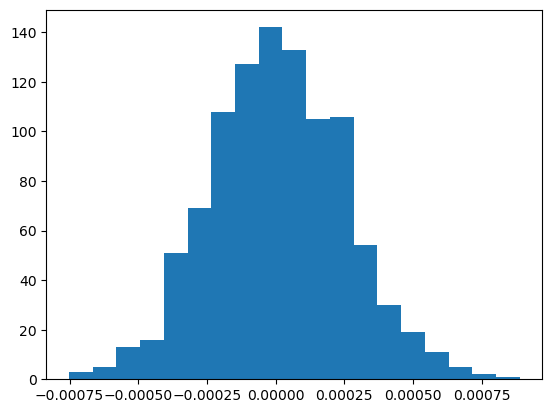

In [23]:
counts_xt, bins_xt = np.histogram(arr_vxTheor, bins = 19)
fig_x, ax_x = plt.subplots()
arr_bins_centers = 0.5 * (bins_xt[1:] + bins_xt[:-1])
ax_x.bar(arr_bins_centers, counts_xt, width = (arr_bins_centers[1] - arr_bins_centers[0]))

In [24]:
bins_x = arr_bins_centers - 0.5 * (arr_bins_centers[1] - arr_bins_centers[0])

In [25]:
bins_x = np.append(bins_x, bins_x[-1] + (bins_x[1] - bins_x[0]))

In [26]:
arr_vx = np.array(df_first['vx'])
counts_xe, bins_xe = np.histogram(arr_vx, bins = bins_x)
#counts_xe, bins_xe = np.histogram(arr_vx, bins = 100)

In [27]:
bins_xe

array([-7.52572838e-04, -6.66157424e-04, -5.79742010e-04, -4.93326595e-04,
       -4.06911181e-04, -3.20495767e-04, -2.34080353e-04, -1.47664938e-04,
       -6.12495242e-05,  2.51658901e-05,  1.11581304e-04,  1.97996719e-04,
        2.84412133e-04,  3.70827547e-04,  4.57242961e-04,  5.43658376e-04,
        6.30073790e-04,  7.16489204e-04,  8.02904618e-04,  8.89320032e-04])

In [28]:
bins_xt

array([-7.52572838e-04, -6.66157424e-04, -5.79742010e-04, -4.93326595e-04,
       -4.06911181e-04, -3.20495767e-04, -2.34080353e-04, -1.47664938e-04,
       -6.12495242e-05,  2.51658901e-05,  1.11581304e-04,  1.97996719e-04,
        2.84412133e-04,  3.70827547e-04,  4.57242961e-04,  5.43658376e-04,
        6.30073790e-04,  7.16489204e-04,  8.02904618e-04,  8.89320032e-04])

In [29]:
arr_bins_e_centers = 0.5 * (bins_xe[1:] + bins_xe[:-1])

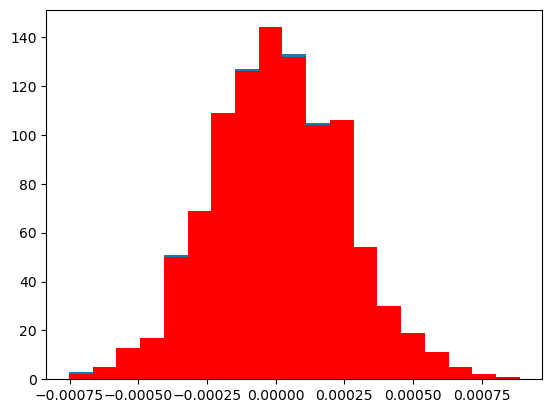

In [30]:
ax_x.bar(arr_bins_e_centers, counts_xe, width = (arr_bins_centers[1] - arr_bins_centers[0]), color = 'red')
fig_x

<BarContainer object of 19 artists>

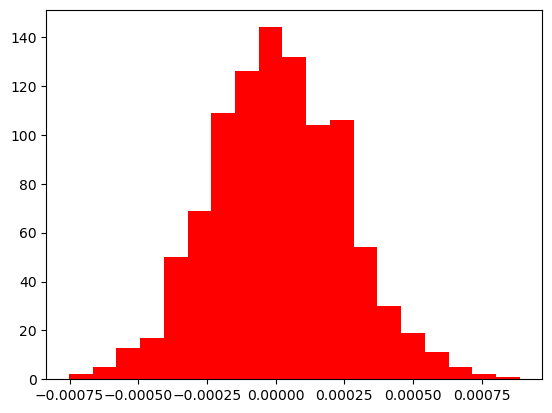

In [31]:
fig_x_e, ax_x_e = plt.subplots()
ax_x_e.bar(arr_bins_e_centers, counts_xe, width = (arr_bins_centers[1] - arr_bins_centers[0]), color = 'red')

In [32]:
std = np.std(arr_vx)

In [33]:
std

0.00024587664119228564

In [34]:
tT = std**2 * dust_mass / cnst.k

In [35]:
tT

1260.1477427696527

In [36]:

for k in range(0, number_of_averaging_iterations):
    arr_discrep = np.zeros((len(arr_resol), len(arr_framerate)))
    for j in range(0, len(arr_framerate)):
        frmrt_j = arr_framerate[j]
        for i in range(0, len(arr_resol)):
            res_i = arr_resol[i]
            df_i = create_art_vels(kin_Tx, kin_Ty, 1000, res_i, frmrt_j, 1510, 7.14E-6, 0, 0, 0, 1751, 0, 400)
            df_i_ff = df_i[df_i['frame'] == 1]
            std_i = np.std(df_i['vx'])
            tT = std_i**2 * dust_mass / cnst.k
            arr_discrep[i, j] = np.abs((kin_Tx - std_i**2 * dust_mass / cnst.k)) / kin_Tx
    arr_discrep_average = arr_discrep_average + arr_discrep / 5

In [37]:
for i in range(0, len(arr_resol)):
    res_i = arr_resol[i]
    df_i = create_art_vels(kin_Tx, kin_Ty, 1000, res_i, 100, 1510, 7.14E-6, 0, 0, 0, 1751, 0, 400)
    df_i_ff = df_i[df_i['frame'] == 1]
    std_i = np.std(df_i['vx'])
    tT = std_i**2 * dust_mass / cnst.k
    arr_discrep[i] = np.abs((kin_Tx - std_i**2 * dust_mass / cnst.k)) / kin_Tx
    

Text(0, 0.5, 'discrepancy (%)')

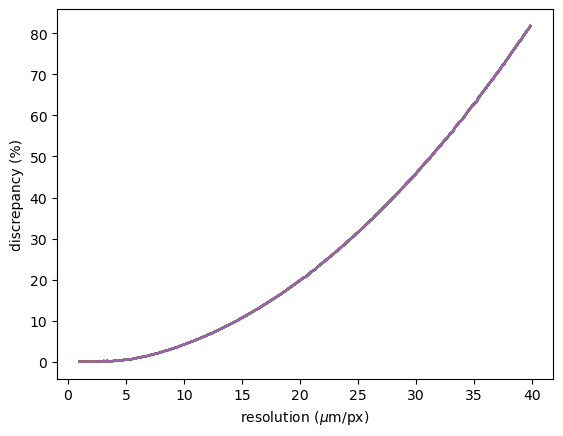

In [38]:
fig, ax = plt.subplots()
ax.plot(arr_resol * 1000000, arr_discrep)
#ax.set_xscale('log')
ax.set_xlabel(r"resolution ($\mu$m/px)")
ax.set_ylabel("discrepancy (%)")

In [39]:
X, Y = np.meshgrid(arr_framerate, arr_resol * 1000000)

(9.0, 30.0)

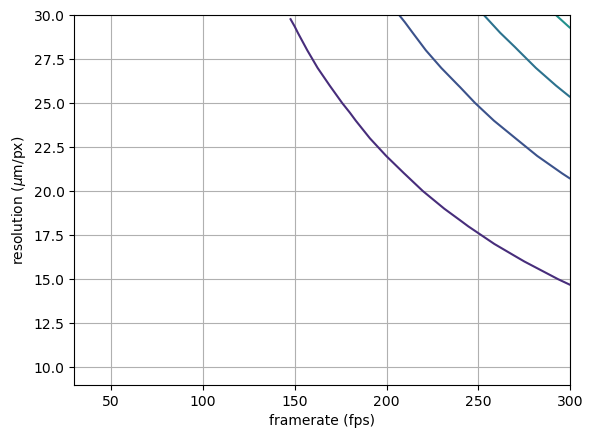

In [40]:
fig4, ax4 = plt.subplots()
khuj = ax4.contour(X, Y, arr_discrep_average)
ax4.set_ylabel(r"resolution ($\mu$m/px)")
ax4.set_xlabel(r"framerate (fps)")
ax4.clabel(khuj,
          inline=True,       # draw labels on the contour lines
          fmt='%1.0f',       # format string for the level numbers
          fontsize=8)
ax4.grid(True)
ax4.set_ylim(9, 30)

<a list of 6 text.Text objects>

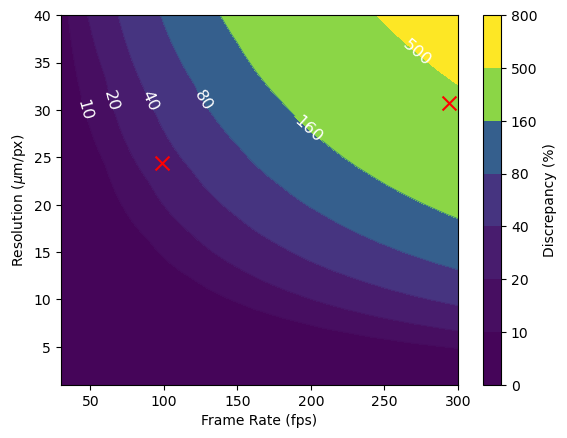

In [ ]:
from matplotlib import colors
# Assuming X, Y, arr_discrep_average are already defined
fig4, ax4 = plt.subplots()

# Filled contours
khuj = ax4.contourf(X, Y, arr_discrep_average, levels= levels_f_contour, norm=colors.Normalize(vmin=0, vmax=400))

# Add colorbar with customized ticks
cbar = plt.colorbar(khuj, ax=ax4, label='Discrepancy (%)')

# Axis labels
ax4.set_ylabel(r"Resolution ($\mu$m/px)")
ax4.set_xlabel(r"Frame Rate (fps)")

# Experimental points
ax4.scatter([99, 294], [24.39, 30.69], marker='x', color='red', label='Experimental points', s=100)

# Set colorbar limits to enforce end at 400
#cbar.ax.set_ylim(0, 400)

line_contours = ax4.contour(X, Y, arr_discrep_average, levels=khuj.levels, linewidths=0.5,norm=colors.Normalize(vmin=0, vmax=400))

ax4.clabel(
    line_contours,
    # khuj,
    fmt='%1.0f',
    fontsize=12,
    colors='white',
    inline=True,
    inline_spacing=2,
)
#plt.savefig(f'Discrepancy_{TeV}eV.png', bbox_inches='tight')
#plt.tight_layout()
#plt.show()


In [45]:
khuj.levels

array([  0.,  80., 160., 240., 320., 400., 480., 560., 640., 720., 800.])

In [51]:
fig4.savefig("contour_discrepancy.png")

In [52]:
fig4.savefig("contour_discrepancy.eps")